In [32]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

### Análisis exploratorio de los datos

In [33]:
data = pd.read_csv("cuentas.csv")
data.head()

,created_at,updated_at,id,deleted_at,is_active,serial,price,discount,status,type,table_id,credit_card,is_deleted
0,9/21/20 17:53,9/21/20 17:59,86,NaN,1,D0000086,19.0,0.0,terminada,domicile,NaN,0,0
1,9/21/20 18:25,9/21/20 19:21,92,NaN,1,D0000092,7.5,0.0,terminada,domicile,NaN,0,0
2,9/23/20 17:49,9/23/20 17:51,98,NaN,1,D0000098,24.5,0.0,terminada,domicile,NaN,0,0
3,9/23/20 18:45,9/23/20 20:02,101,NaN,1,L0000101,39.0,0.0,terminada,local,1.0,0,0
4,9/24/20 19:08,9/24/20 20:00,102,NaN,1,D0000102,34.0,0.0,terminada,domicile,NaN,0,0


C:\Users\53536\AppData\Local\Temp\ipykernel_19936\736903734.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['created_at'] = pd.to_datetime(data['created_at']).dt.date


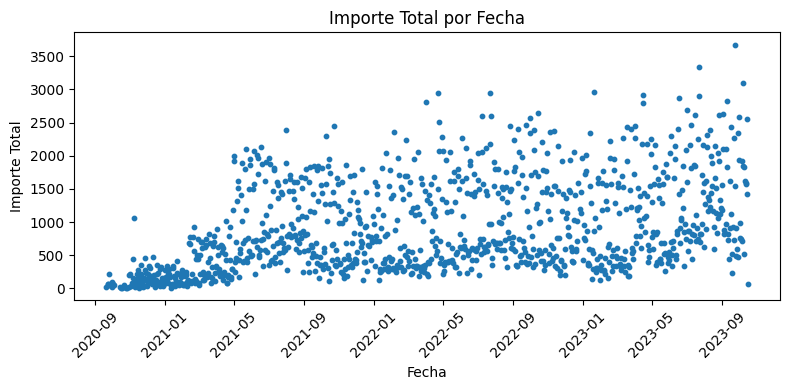

In [34]:
data['created_at'] = pd.to_datetime(data['created_at']).dt.date
Data1 = data.groupby(['created_at'])['price'].sum().reset_index()
plt.figure(figsize=(8, 4))
plt.scatter(Data1['created_at'], Data1['price'], s=10)
plt.xlabel("Fecha")
plt.ylabel('Importe Total')
plt.title('Importe Total por Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

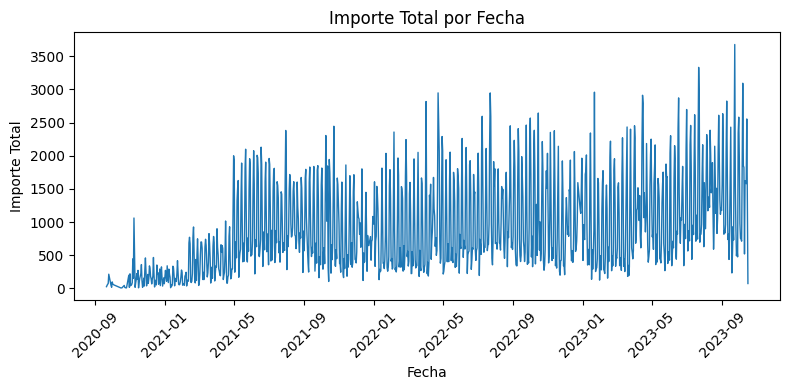

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(Data1['created_at'], Data1['price'], linestyle='-', linewidth=1)
plt.xlabel('Fecha')
plt.ylabel('Importe Total')
plt.title('Importe Total por Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

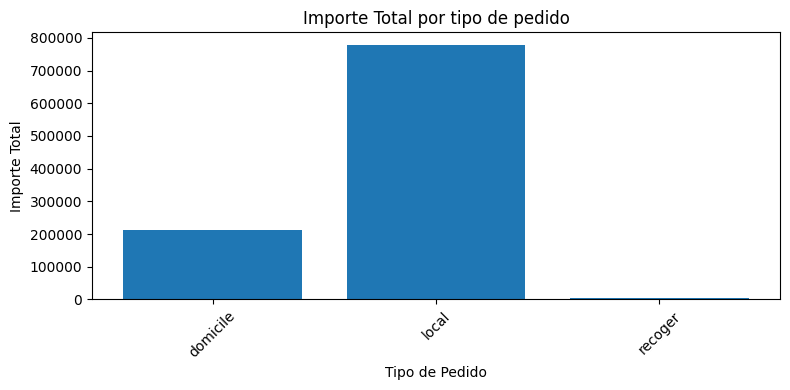

In [36]:
Data2 = data.groupby(['type'])['price'].sum().reset_index()
plt.figure(figsize=(8, 4))
plt.bar(Data2['type'], Data2['price'])
plt.xlabel('Tipo de Pedido')
plt.ylabel('Importe Total')
plt.title('Importe Total por tipo de pedido')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27607 entries, 0 to 27606
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   created_at   27607 non-null  object 
 1   updated_at   27607 non-null  object 
 2   id           27607 non-null  int64  
 3   deleted_at   0 non-null      float64
 4   is_active    27607 non-null  int64  
 5   serial       27607 non-null  object 
 6   price        27607 non-null  float64
 7   discount     27293 non-null  float64
 8   status       27607 non-null  object 
 9   type         27607 non-null  object 
 10  table_id     18159 non-null  float64
 11  credit_card  27607 non-null  int64  
 12  is_deleted   27607 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 2.7+ MB


### Transformación de los datos, Entrenamiento del modelo y Validación de los resultados

In [38]:
data1 = data.groupby('created_at')['price'].sum().reset_index()
data1.columns = ['ds', 'y']
data1 = data1.sort_values(by='ds')
data2 = data1.iloc[195:948] #predecir desde 1-1-2021 a 30-12-2022  ----- 2 años
model = Prophet()
model = Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='year', period=365, fourier_order=1)
model.fit(data2)

start_date = '2023-06-01'
end_date = '2023-10-05'
future = pd.date_range(start=start_date, end=end_date, freq='D')
future = pd.DataFrame({'ds': future})
forecast = model.predict(future)
predictions_df = forecast[['ds', "yhat"]].rename(columns={'ds': 'Fecha', 'yhat': 'Predicción'})
predictions_df['Fecha'] = pd.to_datetime(predictions_df['Fecha']).dt.date

data_main = pd.merge(left=predictions_df, right=data1, how="inner", left_on="Fecha", right_on="ds")
data_main.drop(columns=['ds'], inplace=True)
data_main['diferencia'] = data_main['Predicción'] - data_main['y']
data_main['diferencia'] = data_main['diferencia'].abs()
data_main=data_main[["Fecha","y","Predicción","diferencia"]].rename(columns={'y': 'Importe'})
data_main=round(data_main, 2)

y_true = data_main['Importe']
y_pred = data_main['Predicción']
mae = round(mean_absolute_error(y_true, y_pred), 2)
mape = round(np.mean(np.abs((y_true - y_pred) / y_true) * 100), 2)

print("Predicción de Ventas")
print("Error Absoluto Medio (MAE):", mae)
print("Error Porcentual Absoluto Medio (MAPE):", mape)
data_main.head(10)

13:06:19 - cmdstanpy - INFO - Chain [1] start processing
13:06:19 - cmdstanpy - INFO - Chain [1] done processing


Predicción de Ventas
Error Absoluto Medio (MAE): 293.0
Error Porcentual Absoluto Medio (MAPE): 25.2


,Fecha,Importe,Predicción,diferencia
0,2023-06-01,426.20,730.12,303.92
1,2023-06-02,2040.75,1771.38,269.37
2,2023-06-03,2300.87,2234.52,66.35
3,2023-06-04,706.70,1631.45,924.75
4,2023-06-05,342.20,646.48,304.28
5,2023-06-06,507.20,758.18,250.98
6,2023-06-07,712.20,677.88,34.32
7,2023-06-08,612.57,783.49,170.92
8,2023-06-09,1665.40,1817.06,151.66
9,2023-06-10,2150.90,2271.03,120.13


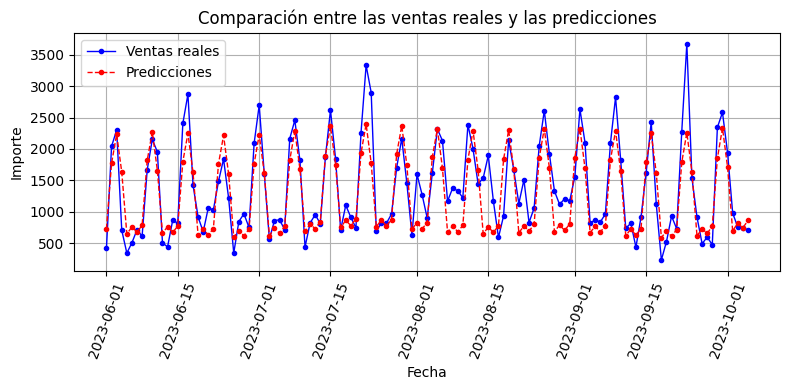

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(data_main['Fecha'], data_main['Importe'], label='Ventas reales', color='blue', marker='o', markersize=3, linewidth=1)
plt.plot(data_main['Fecha'], data_main['Predicción'], label='Predicciones', color='red', linestyle='dashed', marker='o', markersize=3, linewidth=1)
plt.title('Comparación entre las ventas reales y las predicciones')
plt.xlabel('Fecha')
plt.ylabel('Importe')
plt.xticks(rotation=70)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()